<a href="https://colab.research.google.com/github/Tirta2241720045/Machine_Learning/blob/main/Minggu14/Quiz_2_2241720045.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# KUIS 2 PEMBELAJARAN MESIN
Face Detection dan Face Recognition
# Intro

Pada kuis ini, Anda diminta untuk melakukan face detection dan face recognition pada wajah dengan menggunakan dataset primer (dataset wajah yang kalian kumpulkan sendiri).
Spesifikasi pengerjaan kuis yang harus dipehuni adalah,

1. Gunakan pre-trained model haarcascade_frontalface_default.xml untuk face detection
2. Gunakan pre-trained model faceNet untuk face recognition
3. Gunakan model CNN untuk face recognition

# Nama: Tirta Nurrochman Bintang Prawira
# NIM: 2241720045
# No.Absen/Kelas: 27/TI-3A
# Kuis 2 Face Detection dan Face Recognition

In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Tahap 1: Instalasi dan Import Library


In [81]:
!pip install opencv-python-headless tensorflow keras_facenet scikit-learn matplotlib
!pip install keras-facenet

import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Import FaceNet dari keras-facenet
from keras_facenet import FaceNet

# Konfigurasi Path Dataset
dataset_path = '/content/drive/MyDrive/dataset/Minggu14/dataset'
classes = ['khabby_lame', 'rose', 'taylor_swift', 'zayn_malik']

# Tahap 2: Fungsi Utama untuk Memproses Dataset


In [82]:
def load_and_preprocess_dataset(dataset_path, classes, img_size=(160, 160)):
    images = []
    labels = []

    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            # Load dan resize gambar
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img) / 255.0  # Normalisasi

            images.append(img_array)
            labels.append(class_name)

    # Menggunakan LabelEncoder untuk mengubah nama kelas menjadi angka
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)  # Melatih dan mengubah label menjadi angka

    return np.array(images), labels, label_encoder


# Tahap 3: Fungsi Face Detection dengan Haar Cascade

In [83]:
def detect_faces(image_path):
    # Load gambar
    image = cv2.imread(image_path)

    # Load pre-trained Haar Cascade classifier
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Konversi ke grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Deteksi wajah
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Gambar kotak di sekitar wajah
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)

    return image, faces

# Tahap 4: Membangun Model CNN untuk Face Recognition

In [84]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn_model(input_shape, num_classes):
    """
    Membangun model CNN untuk klasifikasi berdasarkan embeddings dari FaceNet
    """
    model = models.Sequential()

    # Lapisan input
    model.add(layers.InputLayer(input_shape=input_shape))

    # Lapisan Dense (Fully Connected)
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Lapisan Output
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Kompilasi model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

def extract_face_embeddings(image_path, model):
    # Deteksi wajah terlebih dahulu
    detected_image, faces = detect_faces(image_path)

    if len(faces) == 0:
        print("No face detected.")
        return None

    # Ekstrak embeddings untuk wajah yang terdeteksi
    face = faces[0]
    (x, y, w, h) = face
    face_image = detected_image[y:y+h, x:x+w]

    # Resize gambar wajah agar sesuai dengan input model FaceNet
    face_image = cv2.resize(face_image, (160, 160))
    face_image = np.expand_dims(face_image, axis=0)
    face_image = face_image / 255.0  # Normalisasi

    # Ekstrak embeddings
    embedding = model.embeddings(face_image)
    return embedding


# Tahap 5: Proses Training dan Evaluasi Model

In [85]:
def train_and_evaluate_with_embeddings(X, y, embeddings):
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(embeddings, y_encoded, test_size=0.2, random_state=42)

    # Create classifier model based on embeddings
    input_shape = (X_train.shape[1],)  # Dimensi embeddings FaceNet
    num_classes = len(classes)
    model = create_classifier_model(input_shape, num_classes)

    # Train model with early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        epochs=20,
        validation_split=0.2,
        batch_size=8,
        callbacks=[early_stopping]
    )

    # Evaluate model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {test_accuracy}")

    # Visualize training history
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, label_encoder

# Tahap 6: Fungsi Prediksi dan Visualisasi

In [91]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from keras.preprocessing import image

def predict_and_visualize(cnn_model, facenet_model, classes, label_encoder, dataset_path):
    """
    Fungsi untuk memilih gambar acak dari setiap kelas, melakukan prediksi menggunakan model CNN,
    dan menampilkan hasil prediksi bersama tingkat kepercayaan serta gambar wajah yang terdeteksi.
    """
    print("Prediksi dan visualisasi gambar...")

    # Pilih gambar acak dari setiap kelas untuk prediksi
    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        img_files = os.listdir(class_path)
        img_file = np.random.choice(img_files)  # Pilih gambar acak dari kelas ini
        img_path = os.path.join(class_path, img_file)

        # Load dan proses gambar
        img = image.load_img(img_path, target_size=(160, 160))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        # Ekstraksi embedding wajah menggunakan model FaceNet
        embedding = facenet_model.embeddings(img_array)

        # Prediksi kelas menggunakan model CNN
        prediction = cnn_model.predict(embedding)
        predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])
        confidence = np.max(prediction) * 100  # Konversi ke persentase

        # Tampilkan gambar dan hasil prediksi
        print(f"Prediksi: {predicted_class[0]}, Confidence: {confidence:.2f}%")

        # Plot gambar dan hasil prediksi
        plt.figure(figsize=(5,5))
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_class[0]} - {confidence:.2f}%")
        plt.axis('off')
        plt.show()

Loading and preprocessing dataset...
Loading FaceNet model...
Extracting face embeddings...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2229 - loss: 1.3855
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2875 - loss: 1.3982
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2333 - loss: 1.3867
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2875 - loss: 1.3880
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2229 - loss: 1.3741
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3042 - loss: 1.3975
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2938 - loss: 1.4080
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2396 - loss: 1.3867 
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2833 - loss: 1.3814
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2500 - loss: 1.4031


Saving CNN model...
CNN model has been saved successfully!
Running prediction and visualization...
Prediksi dan visualisasi gambar...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Prediksi: khabby_lame, Confidence: 25.94%


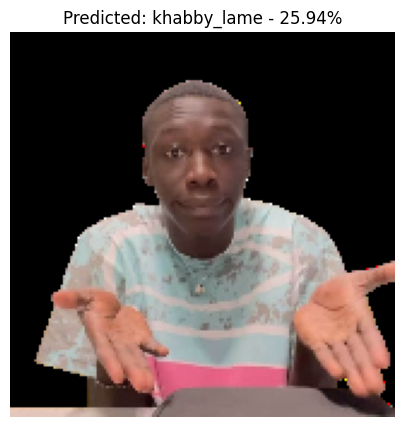

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediksi: khabby_lame, Confidence: 26.09%


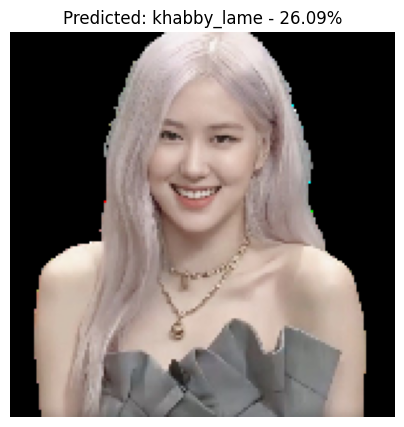

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediksi: taylor_swift, Confidence: 26.14%


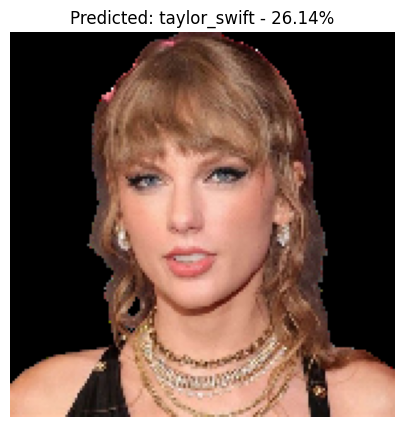

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediksi: khabby_lame, Confidence: 26.98%


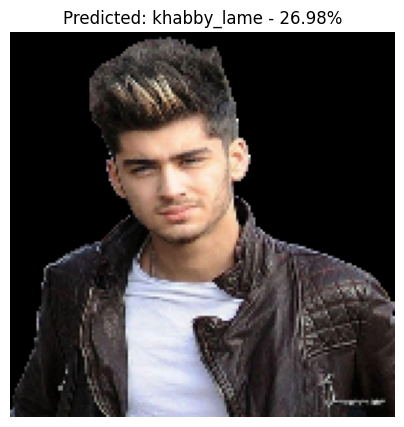

In [92]:
def main():
    # 1. Load Dataset
    print("Loading and preprocessing dataset...")
    dataset_path = '/content/drive/MyDrive/dataset/Minggu14/dataset'  # Path ke dataset wajah
    X_embedding, y_labels, label_encoder = load_and_preprocess_dataset(dataset_path, classes)

    # 2. Inisialisasi Model FaceNet
    print("Loading FaceNet model...")
    facenet_model = FaceNet()

    # 3. Ekstrak Embedding Wajah
    print("Extracting face embeddings...")
    X_embedding = np.array([facenet_model.embeddings(np.expand_dims(img, axis=0)) for img in X_embedding])

    # 4. Ubah dimensi X_embedding agar sesuai input model CNN (dimensi 2D: (None, 512))
    X_embedding = X_embedding.squeeze(axis=1)  # Menghapus dimensi ekstra (None, 1, 512) menjadi (None, 512)

    # 5. Definisikan dan Latih Model CNN untuk Klasifikasi
    print("Creating and training CNN model...")

    cnn_model = create_cnn_model((512,), len(classes))  # Embedding dengan dimensi 512

    # Latih model CNN dengan embedding dan label
    cnn_model.fit(X_embedding, y_labels, epochs=10, batch_size=32)

    # Simpan Model CNN
    print("Saving CNN model...")
    cnn_model.save('/content/drive/MyDrive/dataset/Minggu14/dataset/face_recognition_cnn_model.h5')
    print("CNN model has been saved successfully!")

    # 6. Prediksi dan Visualisasi
    print("Running prediction and visualization...")
    predict_and_visualize(cnn_model, facenet_model, classes, label_encoder, dataset_path)

# Jalankan program utama
main()